<a href="https://colab.research.google.com/github/aSafarpoor/DIP/blob/main/DIP_hw4_99210301.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW4
* name: **Ali Safarpoor Dehkordi**
* sid: **99210301**


# imports:

In [1]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm


#Q1

In [21]:
image_path = "ames1.JPG"
img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)

In [26]:
# based on https://stackoverflow.com/questions/2448015/2d-convolution-using-python-and-numpy
def convolution2d(image, kernel, bias=0):
    kernel = np.flip(kernel)
    m, n = kernel.shape
    if (m == n):
        y, x = image.shape
        y = y - m + 1
        x = x - m + 1
        new_image = np.zeros((y,x))
        for i in tqdm(range(y)):
            for j in range(x):
                new_image[i][j] = np.sum(image[i:i+m, j:j+m]*kernel) + bias
    return new_image

## sobel

In [60]:
class sobelEdgeDetector:
    def __init__(self):
        self.sobel_y = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
        self.sobel_x = np.copy(self.sobel_y).transpose()
        print(self.sobel_x,'\n\n',self.sobel_y)

    def convolution2d(self, image, kernel, bias=0):
        kernel = np.flip(kernel)
        m, n = kernel.shape
        if (m == n):
            y, x = image.shape
            y = y - m + 1
            x = x - m + 1
            new_image = np.zeros((y,x))
            for i in tqdm(range(y)):
                for j in range(x):
                    new_image[i][j] = np.sum(image[i:i+m, j:j+m]*kernel) + bias
        return new_image
    
    def detect(self,img):
        imgx = self.convolution2d(img,self.sobel_x)
        imgy = self.convolution2d(img,self.sobel_y)
        return imgx+imgy

In [62]:
sed = sobelEdgeDetector()
sedimg = sed.detect(img)

[[ 1  0 -1]
 [ 2  0 -2]
 [ 1  0 -1]] 

 [[ 1  2  1]
 [ 0  0  0]
 [-1 -2 -1]]


100%|██████████| 1198/1198 [00:17<00:00, 67.47it/s]


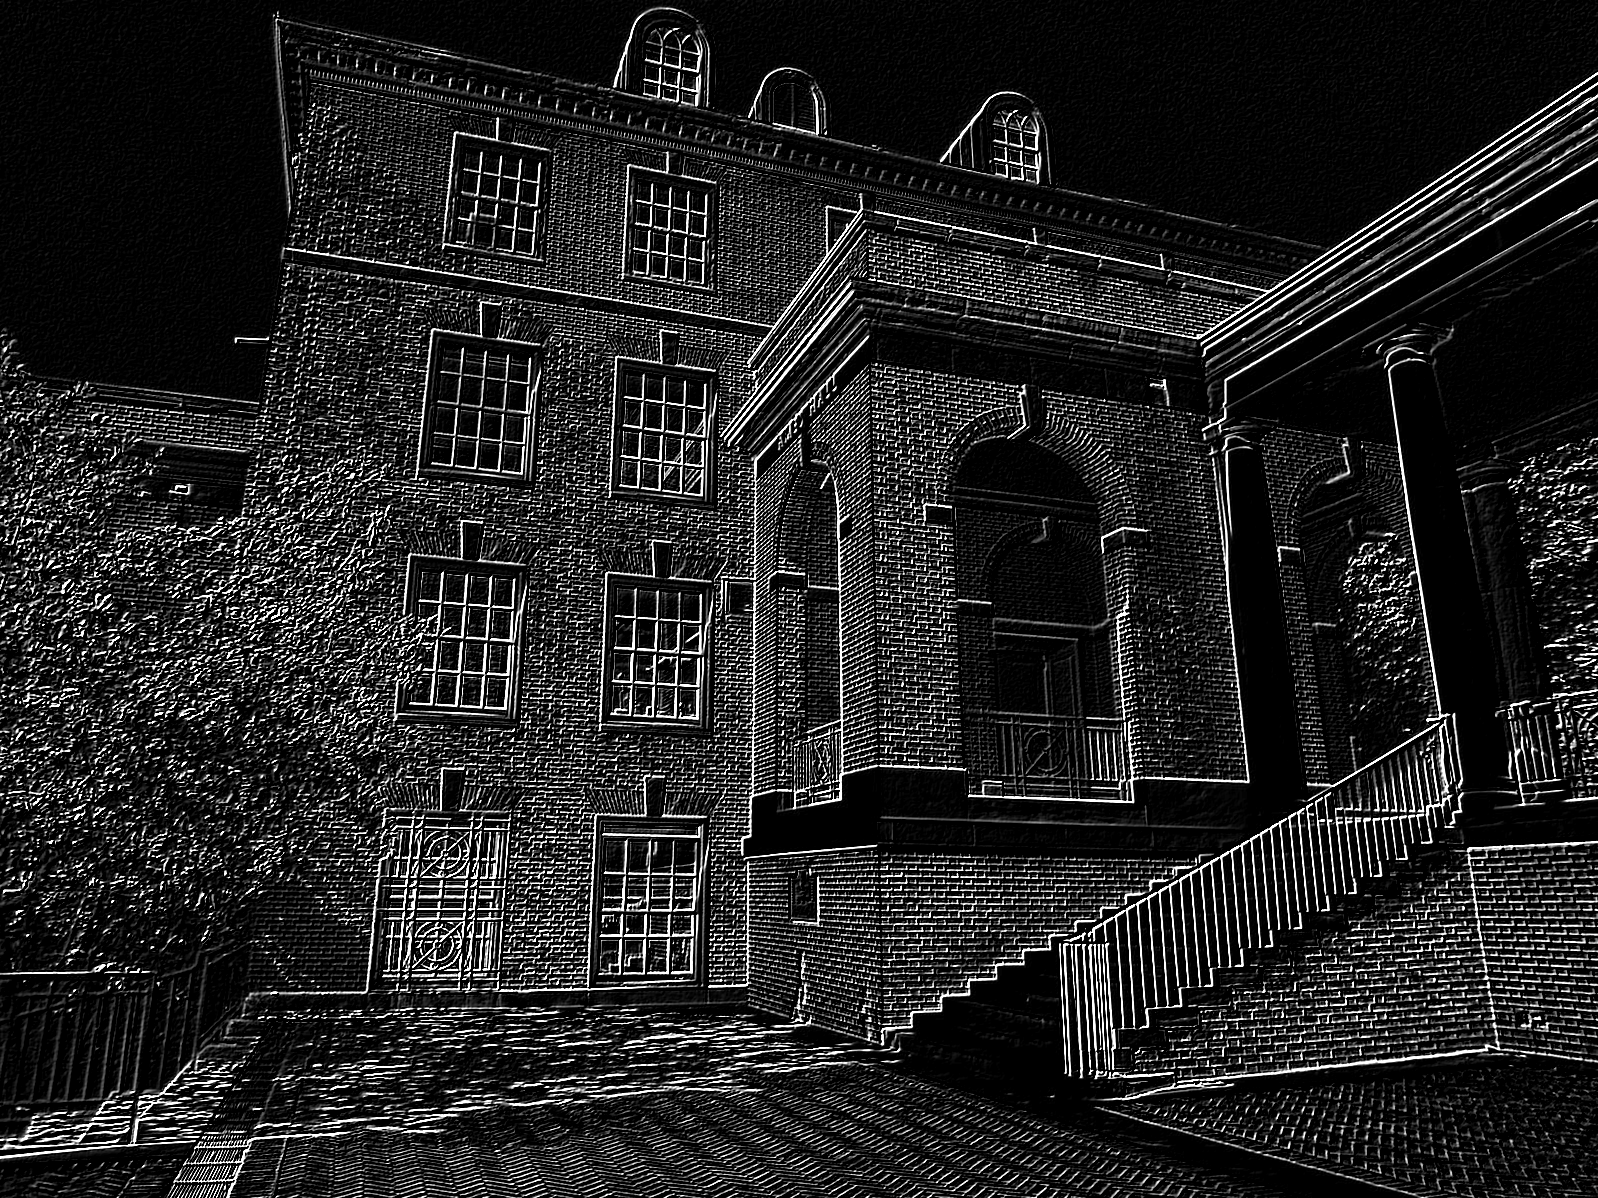

In [63]:
cv2_imshow(sedimg)

## canny

In [66]:
class cannyEdgeDetector:
  def __init__(self, sigma=1, kernel_size=5, lowthreshold=0.05, highthreshold=0.15, weak_pixel=75, strong_pixel=255):
    self.sigma = sigma
    self.kernel_size = kernel_size
    self.lowThreshold = lowthreshold
    self.highThreshold = highthreshold
    self.weak_pixel = weak_pixel
    self.strong_pixel = strong_pixel
    return 
  
  def convolution2d(self, image, kernel, bias=0):
        kernel = np.flip(kernel)
        m, n = kernel.shape
        if (m == n):
            y, x = image.shape
            y = y - m + 1
            x = x - m + 1
            new_image = np.zeros((y,x))
            for i in tqdm(range(y)):
                for j in range(x):
                    new_image[i][j] = np.sum(image[i:i+m, j:j+m]*kernel) + bias
        return new_image

  # Step 1: Noise reduction: Apply Gaussian filter to smooth the image in order to remove the noise
  def gaussian_kernel(self, size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g
  
  # Step 2: Gradient calculation: Find the intensity gradients of the image
  def sobel_filters(self, img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    Ix = cv2.filter2D(img, -1, Kx)
    Iy = cv2.filter2D(img, -1, Ky)

    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255.0
    theta = np.arctan2(Iy, Ix)
    return (G, theta)
  
  # step 3: Non-Maximum Suppression: Apply non-maximum suppression to get rid of spurious response to edge detection
  def non_max_suppression(self, img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1,M-1):
      for j in range(1,N-1):
        try:
          q = 255
          r = 255

          #angle 0
          if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
            q = img[i, j+1]
            r = img[i, j-1]
          #angle 45
          elif (22.5 <= angle[i,j] < 67.5):
            q = img[i+1, j-1]
            r = img[i-1, j+1]
          #angle 90
          elif (67.5 <= angle[i,j] < 112.5):
            q = img[i+1, j]
            r = img[i-1, j]
          #angle 135
          elif (112.5 <= angle[i,j] < 157.5):
            q = img[i-1, j-1]
            r = img[i+1, j+1]

          if (img[i,j] >= q) and (img[i,j] >= r):
            Z[i,j] = img[i,j]
          else:
            Z[i,j] = 0

        except IndexError as e:
            pass

    return Z

  # Step 4: Double threshold: Apply double threshold to determine potential edges
  def threshold(self, img):
    highThreshold = img.max() * self.highThreshold
    lowThreshold = highThreshold * self.lowThreshold

    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)

    weak = np.int32(self.weak_pixel)
    strong = np.int32(self.strong_pixel)

    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)

    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    return (res)

  def hysteresis(self, img):

    M, N = img.shape
    weak = self.weak_pixel
    strong = self.strong_pixel

    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass

    return img
  
  def detect(self,img):   
    
    img_smoothed = self.convolution2d(img, self.gaussian_kernel(self.kernel_size, self.sigma))
    gradientMat, thetaMat = self.sobel_filters(img_smoothed)
    nonMaxImg = self.non_max_suppression(gradientMat, thetaMat)
    thresholdImg = self.threshold(nonMaxImg)
    img_final = self.hysteresis(thresholdImg)
    return img_final

In [67]:
ced = cannyEdgeDetector()
cedimg = sed.detect(img)

100%|██████████| 1198/1198 [00:15<00:00, 75.38it/s]


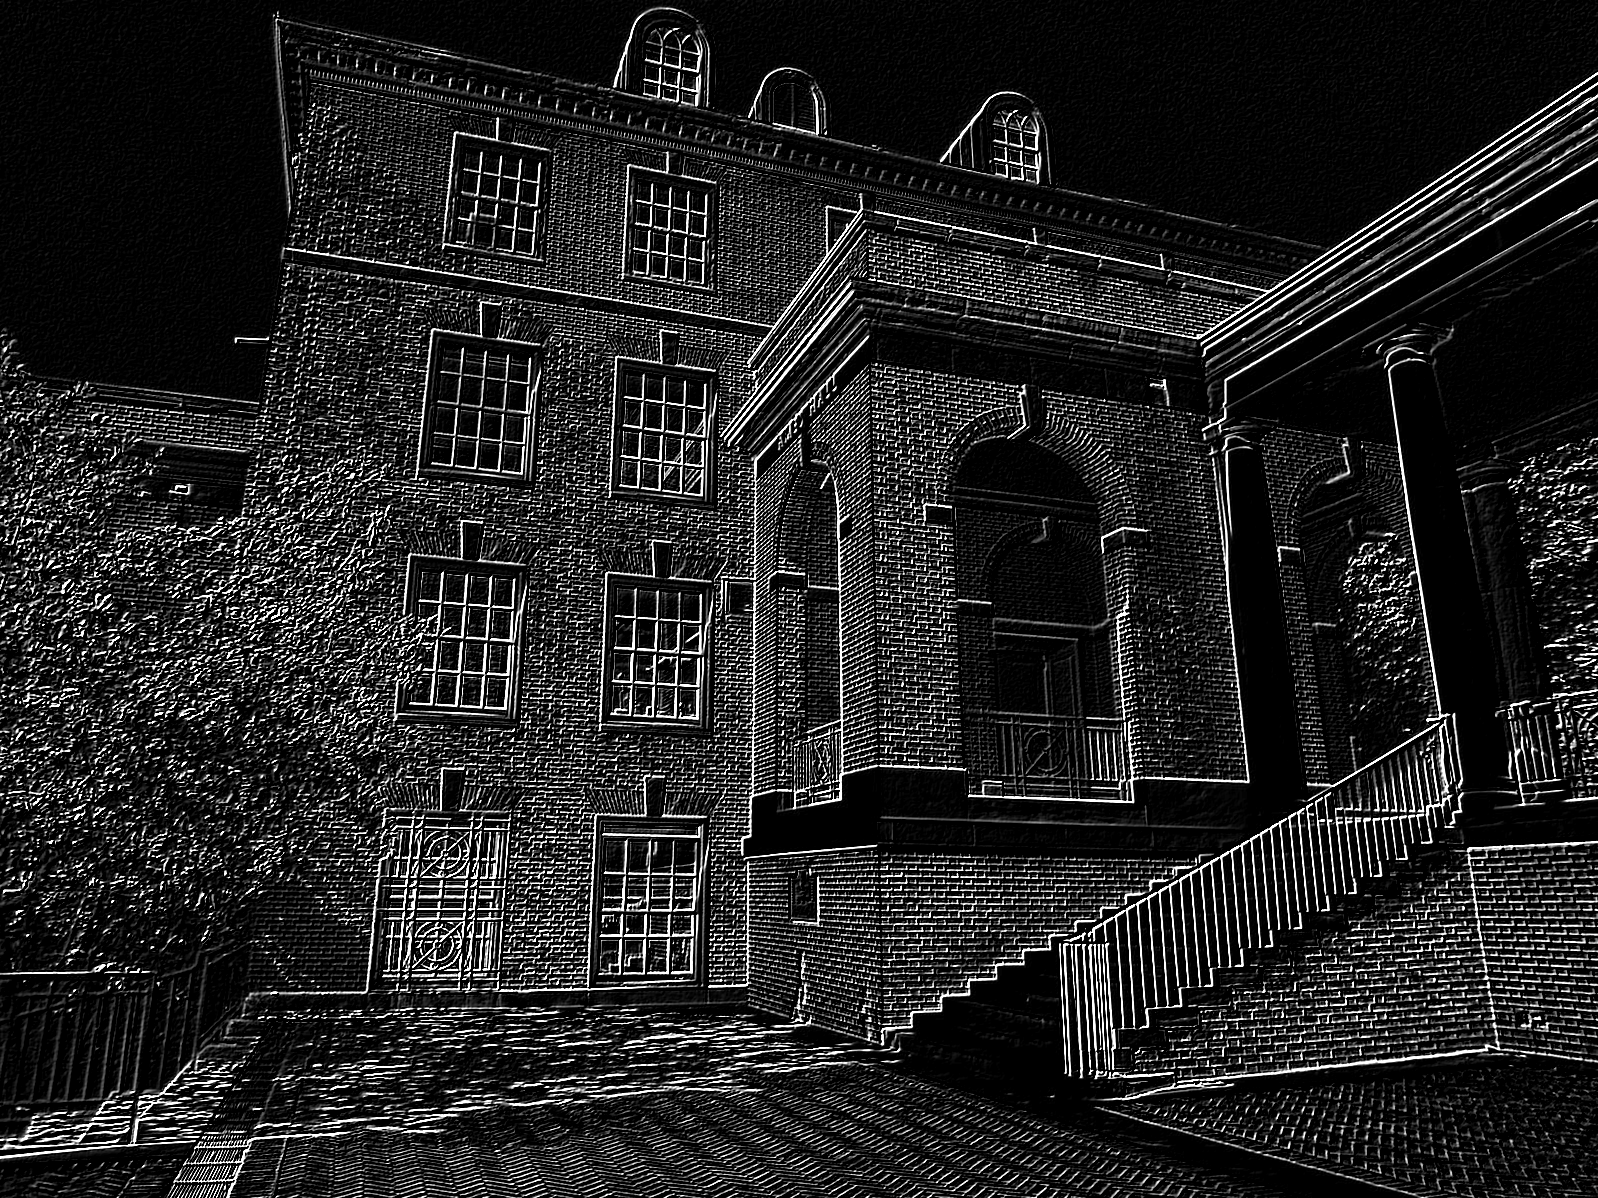

In [69]:
cv2_imshow(cedimg)

## Prewitt

In [70]:
class prewittEdgeDetector:
    def __init__(self):
        self.prewitt_y = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
        self.prewitt_x = np.copy(self.prewitt_y).transpose()
        print(self.prewitt_x,'\n\n',self.prewitt_y)

    def convolution2d(self, image, kernel, bias=0):
        kernel = np.flip(kernel)
        m, n = kernel.shape
        if (m == n):
            y, x = image.shape
            y = y - m + 1
            x = x - m + 1
            new_image = np.zeros((y,x))
            for i in tqdm(range(y)):
                for j in range(x):
                    new_image[i][j] = np.sum(image[i:i+m, j:j+m]*kernel) + bias
        return new_image
    
    def detect(self,img):
        imgx = self.convolution2d(img,self.prewitt_x)
        imgy = self.convolution2d(img,self.prewitt_y)
        return imgx+imgy

In [72]:
ped = prewittEdgeDetector()
pedimg = ped.detect(img)

[[ 1  0 -1]
 [ 1  0 -1]
 [ 1  0 -1]] 

 [[ 1  1  1]
 [ 0  0  0]
 [-1 -1 -1]]


100%|██████████| 1198/1198 [00:15<00:00, 75.94it/s]


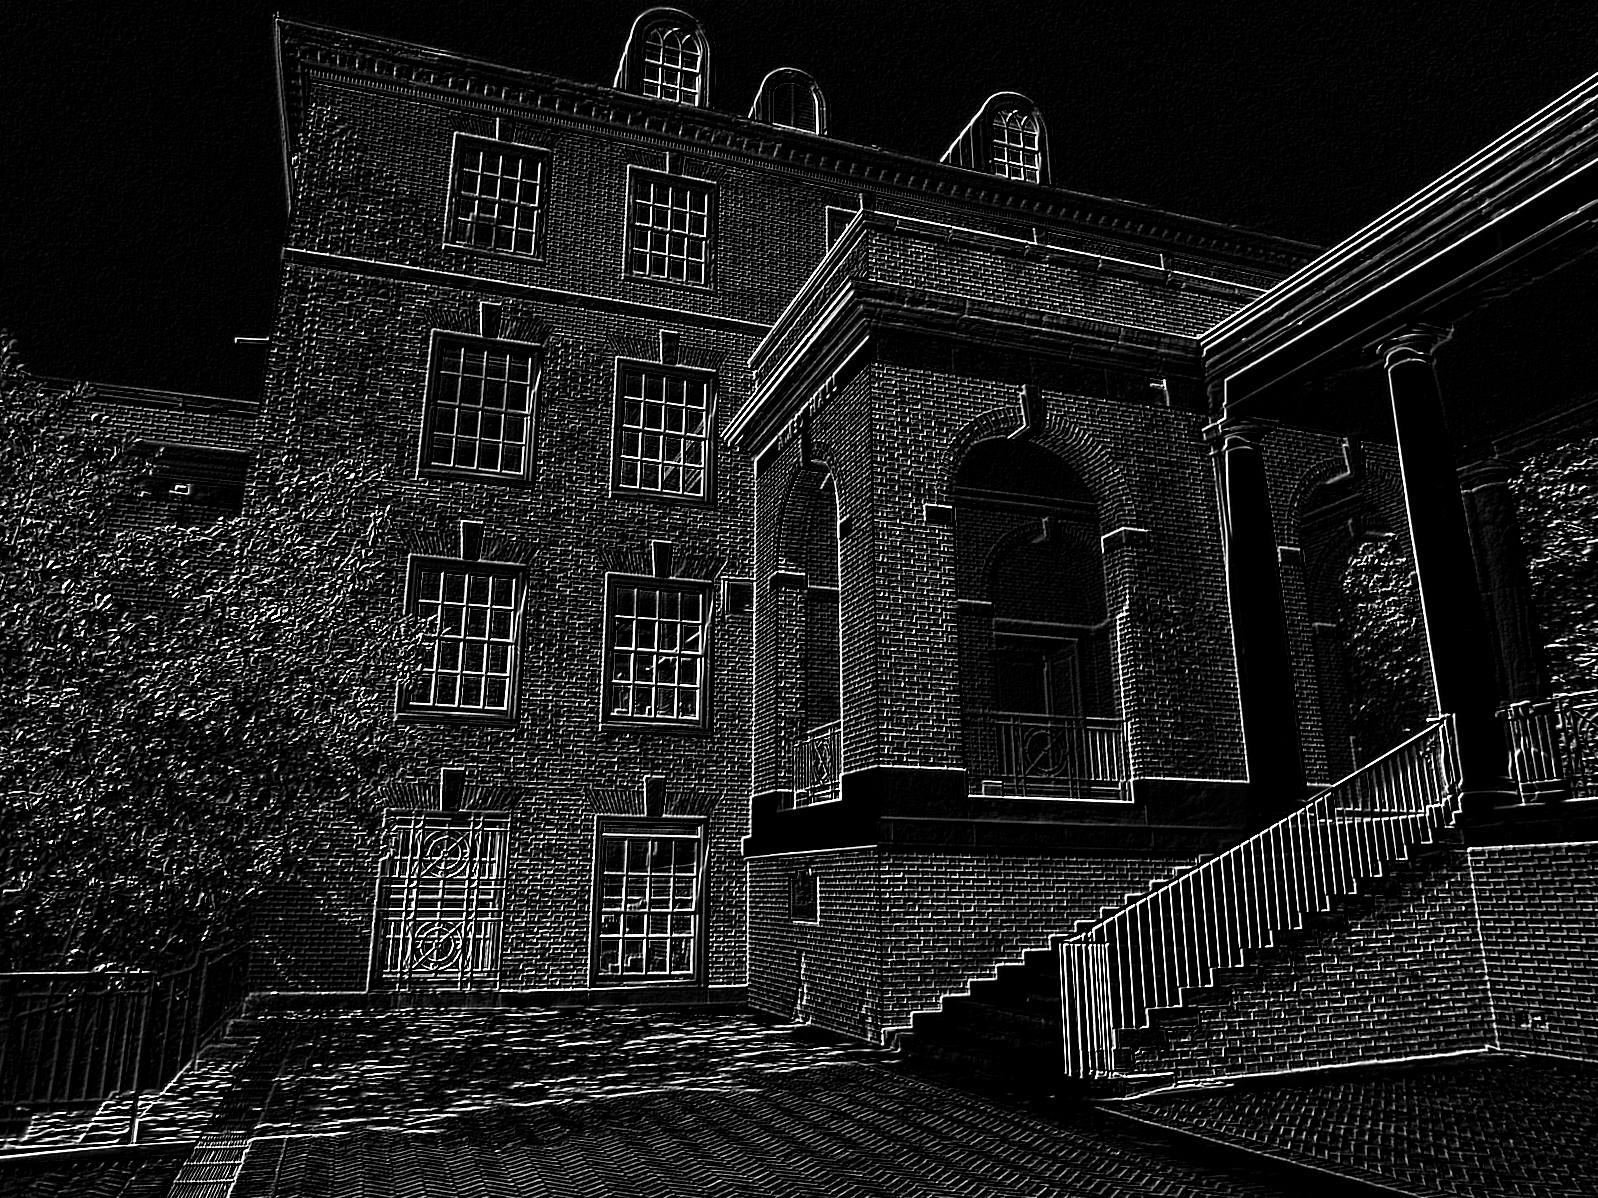

In [73]:
cv2_imshow(pedimg)

In [87]:
class logEdgeDetector:
    def __init__(self):
        self.lap = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])

    def convolution2d(self, image, kernel, bias=0):
        kernel = np.flip(kernel)
        m, n = kernel.shape
        if (m == n):
            y, x = image.shape
            y = y - m + 1
            x = x - m + 1
            new_image = np.zeros((y,x))
            for i in tqdm(range(y)):
                for j in range(x):
                    new_image[i][j] = np.sum(image[i:i+m, j:j+m]*kernel) + bias
        return new_image
    
    def gaussian_kernel(self, size, sigma=1):
        size = int(size) // 2
        x, y = np.mgrid[-size:size+1, -size:size+1]
        normal = 1 / (2.0 * np.pi * sigma**2)
        g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
        return g
    
    def detect(self,img):
        kernel = self.gaussian_kernel(size =5)
        imgg = self.convolution2d(img,kernel)
        imglog = self.convolution2d(imgg,self.lap)
        return imglog
    

In [88]:
loged = logEdgeDetector()
limg = loged.detect(img)

100%|██████████| 1194/1194 [00:15<00:00, 75.86it/s]


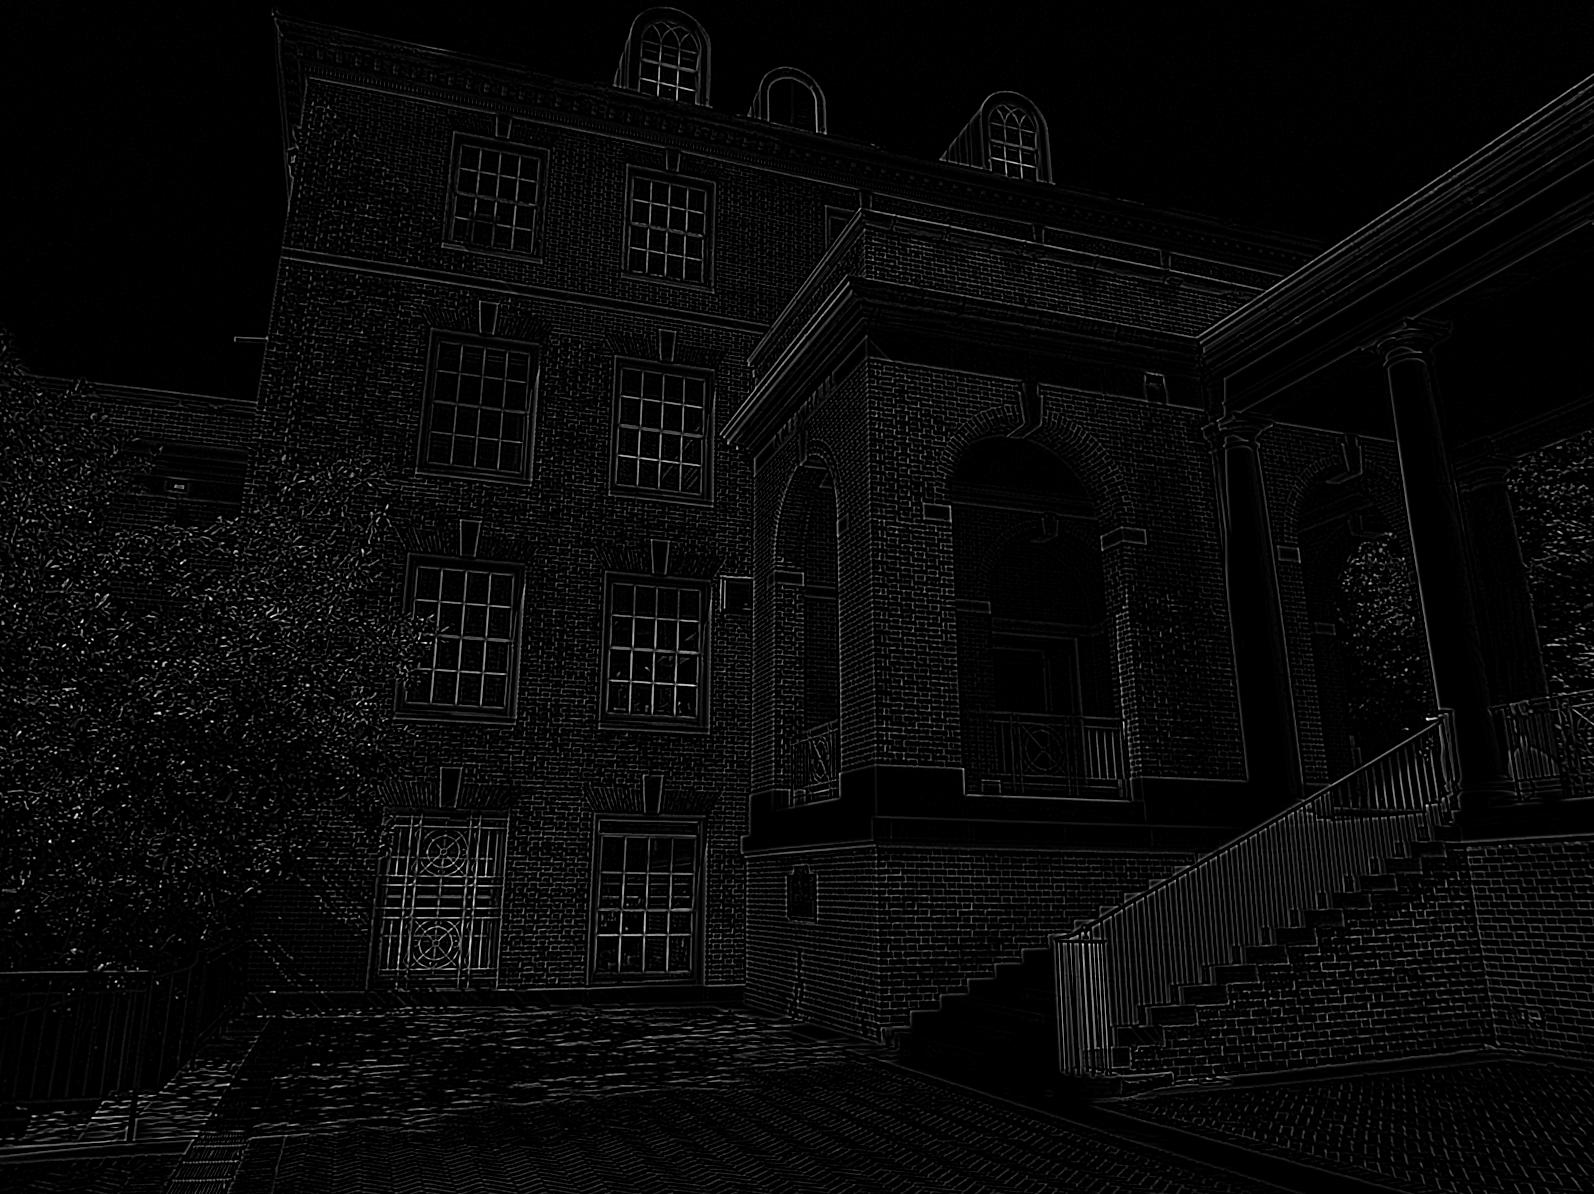

In [89]:
cv2_imshow(limg)

# Q2



In [ ]:
# first you have to upload video

In [ ]:
vidcap = cv2.VideoCapture('F22.mp4')
success,image = vidcap.read()
count = 0
imgs = []
while success:
  imgs.append(image)
  success,image = vidcap.read()

In [ ]:
len(imgs)

1287

In [ ]:
originals = imgs[:]

In [ ]:
imgs = originals[:]
imgs = np.array(imgs) 

In [ ]:
#denoising
kernel = np.ones((5,5),np.float32)/25
dst = cv2.filter2D(imgs[5],-1,kernel)

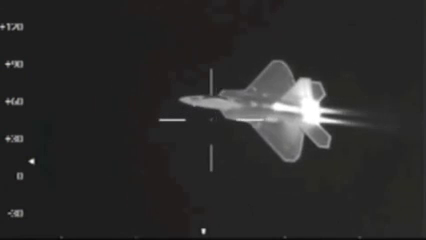

In [ ]:
cv2_imshow(imgs[5])

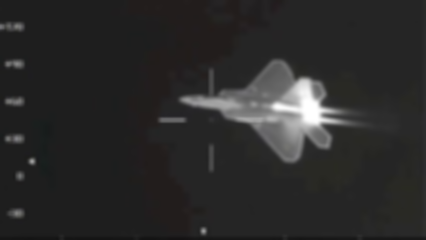

In [ ]:
cv2_imshow(dst)

In [ ]:
#denoising
imgs_temp = []
for img in tqdm(imgs):
    imgs_temp.append(cv2.filter2D(img,-1,kernel))
imgs = imgs_temp[:]
imgs_temp=0

100%|██████████| 1287/1287 [00:02<00:00, 550.44it/s]


In [ ]:
#thresholding
th = 70
imgs_temp = []
for img in tqdm(imgs):
    img[img<th] = 0
    img[img>0] = 255
    imgs_temp.append(img)
imgs = imgs_temp[:]
imgs_temp=0

100%|██████████| 1287/1287 [00:00<00:00, 1832.04it/s]


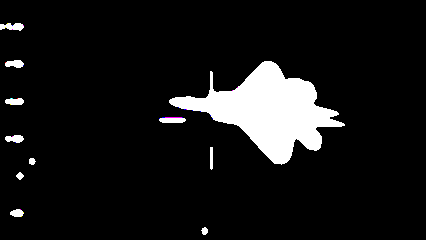

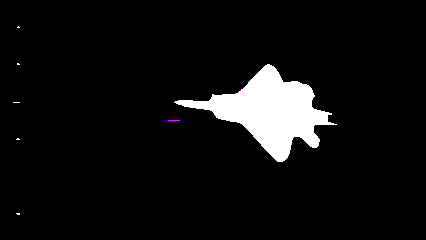

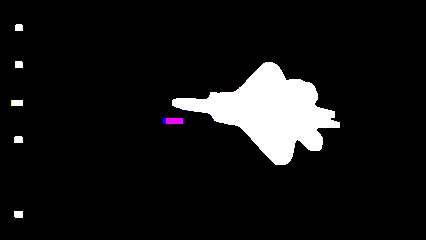

In [ ]:
a = np.copy(imgs[0])
cv2_imshow(a)
kernel1 = np.ones((5,5))
kernel2 = np.ones((2,2))

a = cv2.erode(a, kernel1)
a = cv2.erode(a, kernel2)
cv2_imshow(a)
a = cv2.dilate(a, kernel2)
a = cv2.dilate(a, kernel1)
cv2_imshow(a)


In [ ]:
def erod_dilate(a):
    
    kernel1 = np.ones((5,5))
    kernel2 = np.ones((2,2))
    a = cv2.erode(a, kernel1)
    a = cv2.erode(a, kernel2)
    a = cv2.dilate(a, kernel2)
    a = cv2.dilate(a, kernel1)

    return a

In [ ]:
#thresholding
imgs_temp = []
for img in tqdm(imgs):
    img = erod_dilate(img)
    imgs_temp.append(img)
imgs = imgs_temp[:]
imgs_temp=0

100%|██████████| 1287/1287 [00:02<00:00, 530.92it/s]


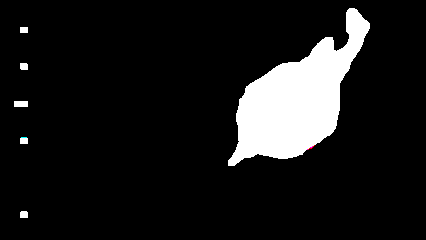

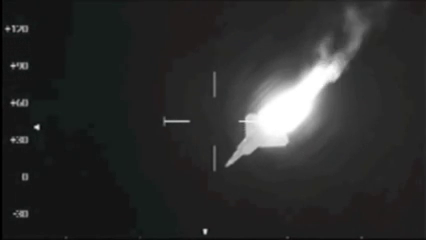

In [ ]:
cv2_imshow(imgs[-10])
cv2_imshow(originals[-10])


In [ ]:
def normalizer(img):
    mi = img.min()
    ma = img.max()
    print(img.min(),img.max())
    img = ((img-mi)/(ma-mi))*255
    print(img.min(),img.max())
    return img

In [ ]:
a = np.array([[1,2,3],[4,5,6],[7,8,9]])
normalizer(a)
# a + a

1 9
0.0 255.0


array([[  0.   ,  31.875,  63.75 ],
       [ 95.625, 127.5  , 159.375],
       [191.25 , 223.125, 255.   ]])

In [ ]:
def green_edge(img):
    a = np.copy(img)
    kernel2 = np.ones((2,2))
    b = cv2.erode(a, kernel1)
    c = a-b
    c = c.transpose()
    c0 = c[1,:,:]
    c0[c0>100]=255
    c0[c0<100]=0
    z = np.zeros(c0.shape)
    c = []
    c.append(z)
    c.append(c0)
    c.append(z)
    c = np.array(c).transpose()
    return c

In [ ]:
imgs_temp = []
for img in tqdm(imgs):
    img = green_edge(img)
    imgs_temp.append(img)
imgs = imgs_temp[:]
imgs_temp=0

100%|██████████| 1287/1287 [00:02<00:00, 552.92it/s]


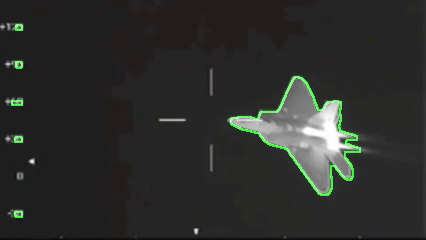

In [ ]:
cv2_imshow(imgs[100]+originals[100])

In [ ]:
len(imgs),len(imgs[0]),len(originals)

(1287, 240, 1287)

In [ ]:
images = [imgs[i]+originals[i] for i in tqdm(range(len(imgs)))]
images = np.array(images)

100%|██████████| 1287/1287 [00:03<00:00, 326.62it/s]


In [ ]:
def generate_video(iamges):
    video_name = 'mygeneratedvideo.avi'
      
    frame = images[0]
  
    # setting the frame width, height width
    # the width, height of first image
    height, width, layers = frame.shape  
  
    video = cv2.VideoWriter(video_name, 0, 1, (width, height)) 
  
    # Appending the images to the video one by one
    for image in tqdm(images): 
        video.write(np.uint8(image)) 
      
    # Deallocating memories taken for window creation
    cv2.destroyAllWindows() 
    video.release()  # releasing the video generated
  
  
# Calling the generate_video function
generate_video(images)

100%|██████████| 1287/1287 [00:01<00:00, 909.64it/s]


In [ ]:
images.shape

(1287, 240, 426, 3)

In [ ]:
# import cv2
# import os

# image_folder = 'images'
# video_name = 'video.avi'

# images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
# frame = cv2.imread(os.path.join(image_folder, images[0]))
# height, width, layers = frame.shape

# video = cv2.VideoWriter(video_name, 0, 1, (width,height))

# for image in images:
#     video.write(cv2.imread(os.path.join(image_folder, image)))

# cv2.destroyAllWindows()
# video.release()